# Criando um Analisador de Sentimento baseado em dicionário

Para ser possível descobrir o que pessoas gostam e não gostam em produtos do mercado pet, é preciso saber quais reviews possuem uma avaliação positiva ou negativa. Como os reviews são construídos por sentenças, que são formadas por palavras, primeiro é necessário decidir se cada palavra é positiva ou negativa e, a partir disso, construir um score de sentimento da sentença.

Clientes também podem emitir suas opiniões sobre produtos dando alguma classificação ou nota. Notas servem como uma boa referência, visto que podem ser interpretados como "pontos", para checar se o analisador de sentimento baseado em dicionário é funcional.

A comparação das classificações e dos escores de sentimento lança luz sobre questões que devem ser consideradas, como a necessidade de lidar com negações. Serão trabalhados também os escores de sentimento e os transformaremos em valores de sentimento. As representações numéricas serão traduzidas em representações textuais, ou seja, positiva, negativa e neutra.

Especialistas em NLP frequentemente seguem este fluxo de trabalho e constroem analisadores de sentimento para obter uma compreensão mais profunda da opinião das pessoas. Analisar os escores de sentimento é especialmente útil se não houver classificações disponíveis de um produto.

## Fluxo de Trabalho
- Carregar o arquivo small_corpus.csv criado anteriormente;
- Tokenizar as sentenças e palavras dos reviews;
- Utilizar léxico de opinião para classificar cada palavra dos reviews;
- Classificar cada review em uma escala de -1 a +1. Quanto maior a pontuação, mais positiva é a revisão.
- Comparar a pontuação das reviews com as avaliações do produto.
- Entender a relação entre as pontuações de sentimento e as avaliações do produto.
- Melhorar analisador de sentimento para reduzir casos contraditórios.
- Finalizar o analisador de sentimento baseado em dicionário, pontuando as reviews novamente com base nas melhorias.
- Exportar resultados para o arquivo de dados (small_corpus), adicionando uma coluna à tabela que contenha as pontuações de sentimento.

## Carregar o corpus menor

In [210]:
import gzip
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
nltk.download('opinion_lexicon')
from nltk.corpus import opinion_lexicon
from nltk.sentiment.util import mark_negation

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


In [211]:
reviews = pd.read_csv('/content/drive/MyDrive/Data Science/Portfólio/small_corpus.csv')

In [212]:
pd.set_option('display.max_colwidth', None)
reviews.head()

,rating,review
0,1.0,Dog didn't care for it. I don't know what the hoopla is about this toy.
1,1.0,"Most of the cans arrived damaged.\nUpdate: I did apply for a refund, knowing that I couldn't ship the case back, and they did refund me the entire cost. I do see that I'm not the only one that has had this problem with this flavor of Friskies. I order mainly the pate Friskies in lots of flavors every single month, and have never had this problem, so it seems the damaged cans are just with this flavor....."
2,1.0,I ordered an XL for my dog who is a mix out and bull mastiff but it's more like a medium. I ordered this before I moved and due to my job I couldn't have my dog so my boyfriend took him. He just tried to put it on him and the head home barely got over his head and the straps were no where near connecting and we loosened every strap. I wish I was able to check before hand because now I can't return it.
3,1.0,"I put my cat on Evo for 2 years, she got a urinary tract infection. I had to change her food. Right after I changed her food. I found out Evo is terrible for animals, the food is causing alot of health problems and death. I got a letter in the mail stating there is a lawsuit against Innova Evo plus all Natura products. I'm currently in the lawsuit myself.. Evo lied about the ingredients in all their products...DO NOT BUY EVO AND NATURA PRODUCTS!!! (such as Innova Evo, California Natural, Healthwise, Mother Nature, and Karma Dog)Google it, it's called PetproductsSettlement.com.. It's for a $2,150,000 settlement"
4,1.0,"My dog had the felt pulled off these things in no time at all (literally)! And the balls are not made of rubber like tennis balls are; they are made of a cheap rubber/plastic that cracks, splits, and crumbles when chewed on. Total disappointment!"


## Tokenização

Tokenização é o processo de dividir um texto em unidades menores, chamadas tokens. Esses tokens podem ser palavras individuais, partes de palavras (como prefixos e sufixos), frases ou símbolos de pontuação. A tokenização é uma etapa fundamental no processamento de linguagem natural e é frequentemente usada para preparar texto para análise por máquinas.

In [213]:
# Tokenização das sentenças
reviews["rev_sent"] = reviews['review'].apply(lambda x: sent_tokenize(str(x)))

# Tokenização das palavras dentro de cada sentença
reviews["rev_word"] = reviews["rev_sent"].apply(lambda x: [word_tokenize(sentence) for sentence in x])

In [214]:
reviews.head()

,rating,review,rev_sent,rev_word
0,1.0,Dog didn't care for it. I don't know what the hoopla is about this toy.,"[Dog didn't care for it., I don't know what the hoopla is about this toy.]","[[Dog, did, n't, care, for, it, .], [I, do, n't, know, what, the, hoopla, is, about, this, toy, .]]"
1,1.0,"Most of the cans arrived damaged.\nUpdate: I did apply for a refund, knowing that I couldn't ship the case back, and they did refund me the entire cost. I do see that I'm not the only one that has had this problem with this flavor of Friskies. I order mainly the pate Friskies in lots of flavors every single month, and have never had this problem, so it seems the damaged cans are just with this flavor.....","[Most of the cans arrived damaged., Update: I did apply for a refund, knowing that I couldn't ship the case back, and they did refund me the entire cost., I do see that I'm not the only one that has had this problem with this flavor of Friskies., I order mainly the pate Friskies in lots of flavors every single month, and have never had this problem, so it seems the damaged cans are just with this flavor.....]","[[Most, of, the, cans, arrived, damaged, .], [Update, :, I, did, apply, for, a, refund, ,, knowing, that, I, could, n't, ship, the, case, back, ,, and, they, did, refund, me, the, entire, cost, .], [I, do, see, that, I, 'm, not, the, only, one, that, has, had, this, problem, with, this, flavor, of, Friskies, .], [I, order, mainly, the, pate, Friskies, in, lots, of, flavors, every, single, month, ,, and, have, never, had, this, problem, ,, so, it, seems, the, damaged, cans, are, just, with, this, flavor, .....]]"
2,1.0,I ordered an XL for my dog who is a mix out and bull mastiff but it's more like a medium. I ordered this before I moved and due to my job I couldn't have my dog so my boyfriend took him. He just tried to put it on him and the head home barely got over his head and the straps were no where near connecting and we loosened every strap. I wish I was able to check before hand because now I can't return it.,"[I ordered an XL for my dog who is a mix out and bull mastiff but it's more like a medium., I ordered this before I moved and due to my job I couldn't have my dog so my boyfriend took him., He just tried to put it on him and the head home barely got over his head and the straps were no where near connecting and we loosened every strap., I wish I was able to check before hand because now I can't return it.]","[[I, ordered, an, XL, for, my, dog, who, is, a, mix, out, and, bull, mastiff, but, it, 's, more, like, a, medium, .], [I, ordered, this, before, I, moved, and, due, to, my, job, I, could, n't, have, my, dog, so, my, boyfriend, took, him, .], [He, just, tried, to, put, it, on, him, and, the, head, home, barely, got, over, his, head, and, the, straps, were, no, where, near, connecting, and, we, loosened, every, strap, .], [I, wish, I, was, able, to, check, before, hand, because, now, I, ca, n't, return, it, .]]"
3,1.0,"I put my cat on Evo for 2 years, she got a urinary tract infection. I had to change her food. Right after I changed her food. I found out Evo is terrible for animals, the food is causing alot of health problems and death. I got a letter in the mail stating there is a lawsuit against Innova Evo plus all Natura products. I'm currently in the lawsuit myself.. Evo lied about the ingredients in all their products...DO NOT BUY EVO AND NATURA PRODUCTS!!! (such as Innova Evo, California Natural, Healthwise, Mother Nature, and Karma Dog)Google it, it's called PetproductsSettlement.com.. It's for a $2,150,000 settlement","[I put my cat on Evo for 2 years, she got a urinary tract infection., I had to change her food., Right after I changed her food., I found out Evo is terrible for animals, the food is causing alot of health problems and death., I got a letter in the mail stating there is a lawsuit against Innova Evo plus all Natura products., I'm currently in the lawsuit myself.. Evo lied about the ingredie

### Léxico de Opinião

In [215]:
positive_wds = set(opinion_lexicon.positive())
negative_wds = set(opinion_lexicon.negative())

In [216]:
def score_sent(sent):
    """Returns a score btw -1 and 1"""
    sent = [mark_negation(e.lower()) for e in sent if e.isalnum()]
    total = len(sent)
    pos = len([e for e in sent if e in positive_wds])
    neg = len([e for e in sent if e in negative_wds])
    if total > 0:
        return (pos - neg) / total
    else:
        return 0

In [217]:
reviews["sent_score"] = reviews["rev_word"].apply(lambda x: [score_sent(sentence) for sentence in x])
reviews["rev_score"]  = reviews["sent_score"].apply(lambda x: sum(x)/len(x))

In [218]:
reviews.sample(5)

,rating,review,rev_sent,rev_word,sent_score,rev_score
3560,5.0,"The fountain replicates an open tap which compels your cat to come and get a drink here. You can also control the flow of the stream. Also, although it is plastic, it is BPA-free!","[The fountain replicates an open tap which compels your cat to come and get a drink here., You can also control the flow of the stream., Also, although it is plastic, it is BPA-free!]","[[The, fountain, replicates, an, open, tap, which, compels, your, cat, to, come, and, get, a, drink, here, .], [You, can, also, control, the, flow, of, the, stream, .], [Also, ,, although, it, is, plastic, ,, it, is, BPA-free, !]]","[0.0, 0.0, 0.0]",0.000000
3154,5.0,Works great. I didn't have any issues with the sticker.,"[Works great., I didn't have any issues with the sticker.]","[[Works, great, .], [I, did, n't, have, any, issues, with, the, sticker, .]]","[1.0, -0.125]",0.437500
3828,5.0,"I have a 65 gallon freshwater setup, planted and ( slightly) overpopulated, running a Fluval 406 at 3/4 flow. Water quality has been right on target, but I have been having an awful time with algae in the water. Yes, I know it is a sign of a healthy tank, but I want to see my beautiful fish! I hated throwing algaecide in the water every 3-4 days to kill the bloom, then clarifier, then then micron polisher in the Magnum HOT that I use to scrub the water.\n\nThere had to be a better way.\n\nI have had the Green Killing Machine running for a week, and I will take it off today as it has done it's job. The water is sparkling! It is far better than any other approach. Other people who ran it mentioned they don't run it all the time, so I will try it off for a while and see how it goes.\n\nSet up took a few minutes, as the directions were photos and it wasn't clear which part went where.... but overall, easy setup.\n\nSo far- very happy!!\n\n*****UPDATE*******\nPurchased in February 2015, it is now June 2015. Four months, and the water has been sparkling the whole time! I decided to let it run continuously since the tank is overpopulated. Still very pleased!","[I have a 65 gallon freshwater setup, planted and ( slightly) overpopulated, running a Fluval 406 at 3/4 flow., Water quality has been right on target, but I have been having an awful time with algae in the water., Yes, I know it is a sign of a healthy tank, but I want to see my beautiful fish!, I hated throwing algaecide in the water every 3-4 days to kill the bloom, then clarifier, then then micron polisher in the Magnum HOT that I use to scrub the water., There had to be a better way., I have had the Green Killing Machine running for a week, and I will take it off today as it has done it's job., The water is sparkling!, It is far better than any other approach., Other people who ran it mentioned they don't run it all the time, so I will try it off for a while and see how it goes., Set up took a few minutes, as the directions were photos and it wasn't clear which part went where.... but overall, easy setup., So far- very happy!!, *****UPDATE*******\nPurchased in February 2015, it is now June 2015., Four months, and the water has been sparkling the whole time!, I decided to let it run continuously since the tank is overpopulated., Still very pleased!]","[[I, have, a, 65, gallon, freshwater, setup, ,, planted, and, (, slightly, ), overpopulated, ,, running, a, Fluval, 406, at, 3/4, flow, .], [Water, quality, has, been, right, on, target, ,, but, I, have, been, having, an, awful, time, with, algae, in, the, water, .], [Yes, ,, I, know, it, is, a, sign, of, a, healthy, tank, ,, but, I, want, to, see, my, beautiful, fish, !], [I, hated, throwing, algaecide, in, the, water, every, 3-4, days, to, kill, the, bloom, ,, then, clarifier, ,, then, then, micron, polisher, in, the, Magnum, HOT, that, I, use, to, scrub, the, water, .], [There, had, to, be, a, better, way, .], [I, have, had, the, Green, Killing, Machine, running, for, a, week, ,, and, I, will, take, it, off, tod

## Comparação entre a pontuação das reviews com as avaliações do produto

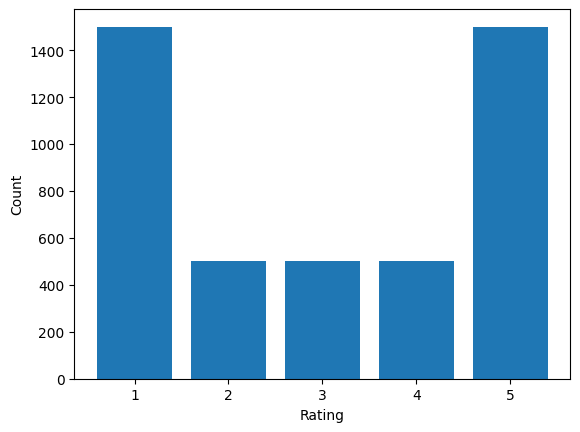

In [219]:
import matplotlib.pyplot as plt

# Supondo que 'reviews' seja o seu DataFrame e contenha a coluna 'rating'

# Obtém as contagens de cada classificação
rating_counts = reviews['rating'].value_counts()

# Obtém os valores únicos de classificação e suas contagens
ratings = rating_counts.index
counts = rating_counts.values

# Plota o gráfico de barras
plt.bar(x=ratings, height=counts)

# Adiciona rótulos aos eixos
plt.xlabel('Rating')
plt.ylabel('Count')

# Mostra o gráfico
plt.show()

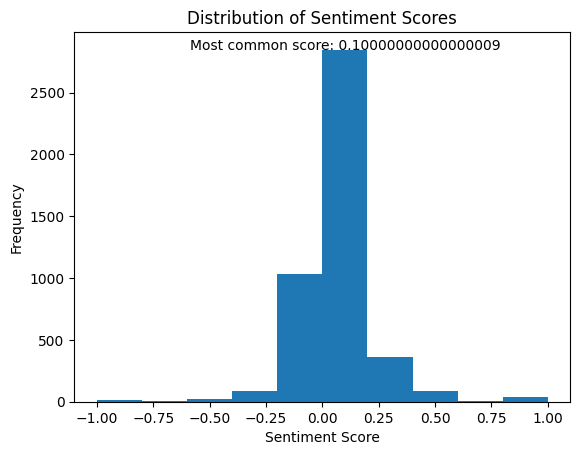

In [220]:
import numpy as np
import matplotlib.pyplot as plt

# Calcula o histograma dos scores de sentimento
scores = reviews['rev_score']
hist, bins = np.histogram(scores, bins=10)  # O número de bins pode ser ajustado conforme necessário

# Encontra o bin com a contagem mais alta
indice_max_contagem = np.argmax(hist)
score_mais_comum = (bins[indice_max_contagem] + bins[indice_max_contagem + 1]) / 2

# Plota o histograma
plt.bar(bins[:-1], hist, width=np.diff(bins), align='edge')

# Adiciona rótulos aos eixos
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')

# Adiciona título
plt.title('Distribution of Sentiment Scores')

# Adiciona texto indicando o score mais comum
plt.text(score_mais_comum, max(hist), f'Most common score: {score_mais_comum}', ha='center')

# Mostra o gráfico
plt.show()

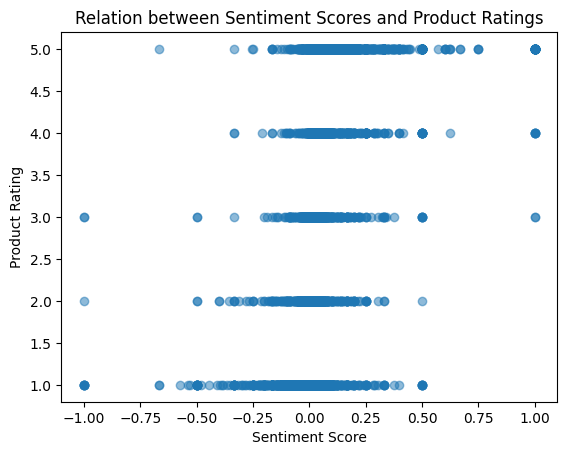

In [221]:
import matplotlib.pyplot as plt

# Crie um gráfico de dispersão dos scores de sentimento em relação às classificações dos produtos
plt.scatter(reviews['rev_score'], reviews['rating'], alpha=0.5)

# Adicione rótulos aos eixos
plt.xlabel('Sentiment Score')
plt.ylabel('Product Rating')

# Adicione um título ao gráfico
plt.title('Relation between Sentiment Scores and Product Ratings')

# Exiba o gráfico
plt.show()

É possível perceber que existem algumas contradições nos resultados, basta perceber que há Sentiment Score negativos, mas com Product Rating alto. É preciso entender se há alguma correlação estatisticamente relevante entre as variáveis. Um outro exemplo de contradição é a frase 'not bad', que é entendida como uma frase negativa, enquanto deveria ser interpretado como uma aprovação ou satisfação moderada.

### Correlação

In [222]:
from scipy.stats import pearsonr, spearmanr

corr1, _ = pearsonr(reviews['rating'], reviews['rev_score'])
print(corr1)

# Spearman rank correlation says there's weak correlation btw review score
# and sentiment
scor1, _ = spearmanr(reviews['rating'], reviews['rev_score'])

print(scor1)

0.4410964863266555
0.5588816983360199


Em resumo, ambos os coeficientes indicam que há alguma relação entre as classificações dos produtos e os scores de sentimento das revisões, mas essa relação não é muito forte. A correlação de Spearman tende a ser menos sensível a outliers e pode ser mais apropriada para os dados, considerando que estamos lidando com scores e classificações.

## Verificando Casos Contraditórios

In [223]:
reviews[(reviews['rating']==5.0) & (reviews['rev_score']<-0.1)].sample(5)

,rating,review,rev_sent,rev_word,sent_score,rev_score
3709,5.0,Only product I will use on my dog. No adverse reaction.,"[Only product I will use on my dog., No adverse reaction.]","[[Only, product, I, will, use, on, my, dog, .], [No, adverse, reaction, .]]","[0.0, -0.3333333333333333]",-0.166667
4345,5.0,God rid of my pit bull's eye infection.,[God rid of my pit bull's eye infection.],"[[God, rid, of, my, pit, bull, 's, eye, infection, .]]",[-0.125],-0.125000
3712,5.0,my picky dog would take these no problem.,[my picky dog would take these no problem.],"[[my, picky, dog, would, take, these, no, problem, .]]",[-0.25],-0.250000
4413,5.0,Dont hates them.,[Dont hates them.],"[[Dont, hates, them, .]]",[-0.3333333333333333],-0.333333
3020,5.0,Stops itchy scratchy.,[Stops itchy scratchy.],"[[Stops, itchy, scratchy, .]]",[-0.6666666666666666],-0.666667


### Situações contraditórias
Foi percebido uma tendência de não identificar reviews positivas que contenham palavras negativas, como:
- No adverse reaction;
- No problem;
- Don't hates them;



## Melhorar analisador de sentimento para reduzir casos contraditórios

A opção para lidar com casos contraditórios e negação no analisador de sentimento é usar a função mark_negation do módulo sentiment.utils do NLTK.

A função mark_negation do NLTK é projetada para lidar especificamente com casos de negação em análise de sentimento. Ela marca todas as palavras que ocorrem após uma negação com um sufixo especial (_NEG por padrão), para indicar que elas estão negadas. Isso pode ajudar a melhorar a precisão da análise de sentimento em casos onde a negação está presente.

In [224]:
def score_sent_v2(sent):
    """Returns a score btw -1 and 1"""
    sent = [e.lower() for e in sent if e.isalnum()]
    mark = mark_negation(sent)
    total = len(mark)
    pos = len([e for e in mark if e in positive_wds])
    neg = len([e for e in mark if e in negative_wds])
    if total > 0:
        return (pos - neg) / total
    else:
        return 0

In [225]:
reviews["sent_score_v2"] = reviews["rev_word"].apply(lambda x: [score_sent_v2(sentence) for sentence in x])
reviews["rev_score_v2"]  = reviews["sent_score_v2"].apply(lambda x: sum(x)/len(x))

In [226]:
reviews.sample(5)

,rating,review,rev_sent,rev_word,sent_score,rev_score,sent_score_v2,rev_score_v2
1058,1.0,Complete waste of money. Our 15 pond terrier destroyed it in just a few days.,"[Complete waste of money., Our 15 pond terrier destroyed it in just a few days.]","[[Complete, waste, of, money, .], [Our, 15, pond, terrier, destroyed, it, in, just, a, few, days, .]]","[-0.25, 0.0]",-0.125000,"[-0.25, 0.0]",-0.125000
2151,3.0,not the best harness out there. feels a little cheap,"[not the best harness out there., feels a little cheap]","[[not, the, best, harness, out, there, .], [feels, a, little, cheap]]","[0.16666666666666666, -0.25]",-0.041667,"[0.0, -0.25]",-0.125000
3538,5.0,Good for wild animals. I donated them based on a request by the San Diego Humane Society and Project WIldlife (whihc rescues wildlife which is injured and babies).,"[Good for wild animals., I donated them based on a request by the San Diego Humane Society and Project WIldlife (whihc rescues wildlife which is injured and babies).]","[[Good, for, wild, animals, .], [I, donated, them, based, on, a, request, by, the, San, Diego, Humane, Society, and, Project, WIldlife, (, whihc, rescues, wildlife, which, is, injured, and, babies, ), .]]","[0.0, 0.041666666666666664]",0.020833,"[0.0, 0.041666666666666664]",0.020833
1576,2.0,"Just moved and although it worked in the previous house, it doesn't see, to be working in this house","[Just moved and although it worked in the previous house, it doesn't see, to be working in this house]","[[Just, moved, and, although, it, worked, in, the, previous, house, ,, it, does, n't, see, ,, to, be, working, in, this, house]]",[0.05263157894736842],0.052632,[0.05263157894736842],0.052632
3695,5.0,This product really is fantastic to have and is great quality and is safe for such a cheap price.,[This product really is fantastic to have and is great quality and is safe for such a cheap price.],"[[This, product, really, is, fantastic, to, have, and, is, great, quality, and, is, safe, for, such, a, cheap, price, .]]",[0.10526315789473684],0.105263,[0.10526315789473684],0.105263


In [227]:
from scipy.stats import pearsonr, spearmanr

corr1, _ = pearsonr(reviews['rating'], reviews['rev_score_v2'])
print(corr1)

# Spearman rank correlation says there's weak correlation btw review score
# and sentiment
scor1, _ = spearmanr(reviews['rating'], reviews['rev_score_v2'])

print(scor1)

0.4668528572594834
0.6114724372999993


A melhoria nas correlações após a aplicação do mark_negation sugere que a técnica está ajudando a capturar nuances mais sutis de sentimento nos textos, especialmente em casos onde a negação está presente.

O aumento dos valores desses coeficientes indica uma melhoria na correlação entre os ratings dos reviews e os scores atribuídos pelo analisador de sentimento. Isso sugere que o analisador de sentimento melhorou sua capacidade de capturar a tendência geral de sentimentos expressos nos reviews, tornando as classificações mais alinhadas com a percepção humana dos sentimentos expressos nos textos.








In [228]:
df_final = reviews[['rating','review','rev_score_v2']]
df_final.sample(5)

,rating,review,rev_score_v2
526,1.0,Most of these were broken and not intact. Dragon wouldn't eat them.,-0.062500
1559,2.0,Glenda the good witch costume is very cute but is more sheer than pictured. The hat fell apart as soon as I put it on my dogs head. Disappointed,-0.309524
1619,2.0,Did not work for our lab,0.000000
3215,5.0,"Very well made, great for my rottie. Love the storage underneath as well, really handy. Would definitely purchase again!",0.220238
397,1.0,works until your dog gets what you are doing. There is no short cut for training,0.055556


In [229]:
df_final.to_csv("/content/drive/MyDrive/Data Science/Portfólio/small_corpus.csv", index=False)